# Import Statements

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

'/home/nils/projects/uq-regression-box'

In [2]:
from uq_method_box.datamodules import ToySineDatamodule
from uq_method_box.models import MLP
from uq_method_box.uq_methods import BaseModel, CQR
from uq_method_box.viz_utils import (
    plot_toy_data,
    plot_predictions,
    plot_calibration_uq_toolbox,
)
from uq_method_box.eval_utils import (
    compute_epistemic_uncertainty,
    compute_aleatoric_uncertainty,
    compute_quantiles_from_std,
    compute_empirical_coverage,
    compute_predictive_uncertainty,
    compute_sample_mean_std_from_quantile,
)
from uq_method_box.train_utils import basic_train_loop, NLL, QuantileLoss
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplace import Laplace

%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["figure.figsize"] = [28, 9]

In [4]:
# track results for analysis late
results_dict = {}

# Generate and visualize data

In [5]:
dm = ToySineDatamodule()
X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

X_test_cpu = torch.clone(X_test).numpy()
y_test_cpu = torch.clone(y_test).numpy()

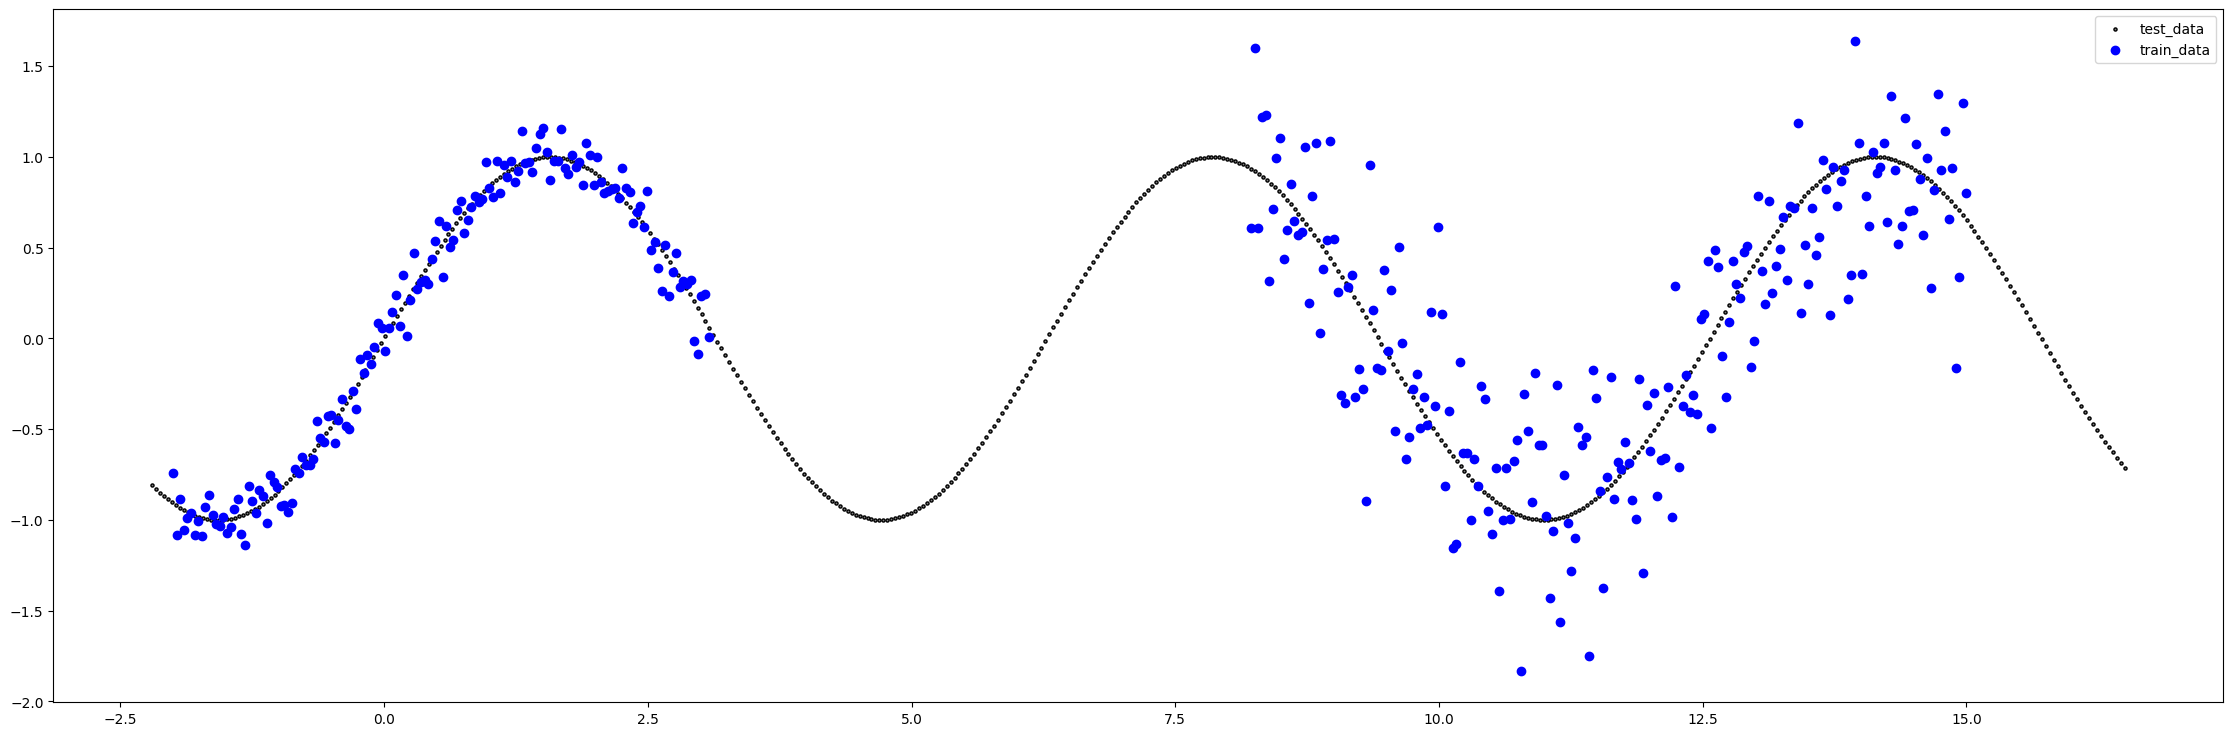

(None, None)

In [6]:
plot_toy_data(X_train, y_train, X_test_cpu, y_test_cpu), plt.close()

# Methods

## MLE Model no UQ

In [7]:
det_model = MLP()

# train_model
basic_train_loop(det_model, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    y_preds_det = det_model(X_test)

100%|██████████| 1000/1000 [00:09<00:00, 105.79it/s, loss=0.09178660064935684]


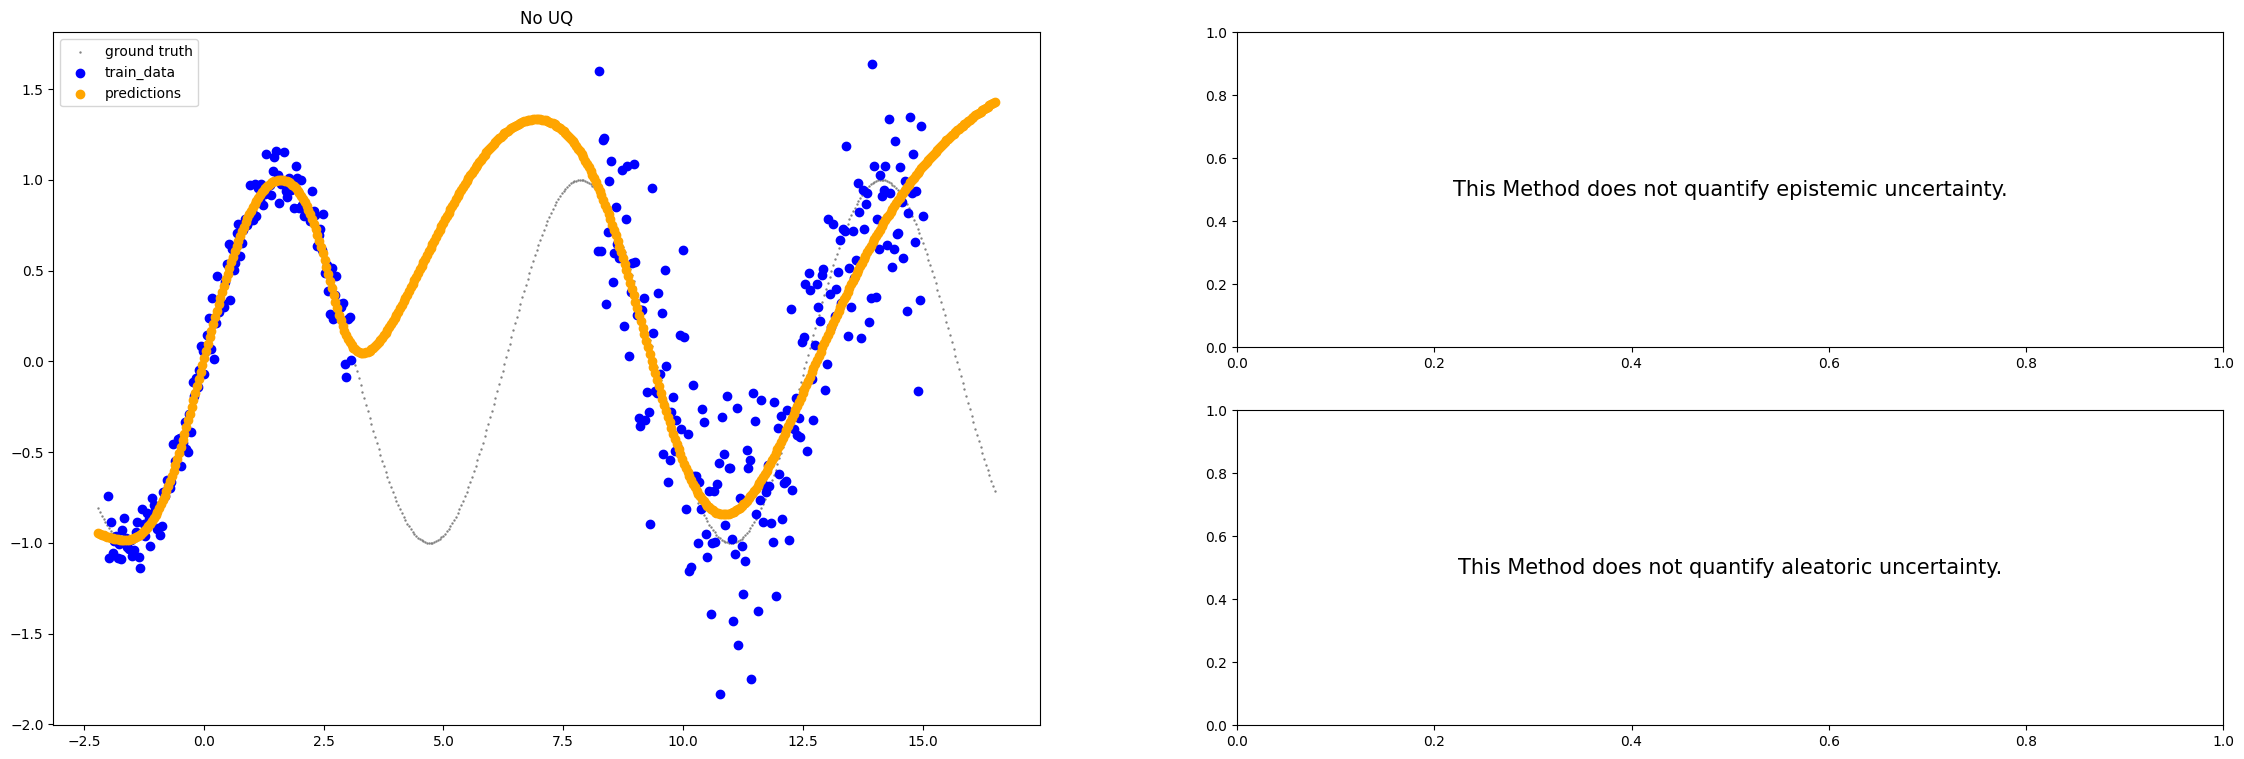

In [8]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

## Deterministic MLP that predicts parameters of Gaussian

In [ ]:
det_uq_model = MLP(n_outputs=2, n_hidden=[50, 50], predict_sigma=True)

# train model
basic_train_loop(det_uq_model, NLL(), train_loader, lr=1e-2, n_epochs=2000)

# get predictions
with torch.no_grad():
    y_preds_det_uq = det_uq_model(X_test).cpu().numpy()

det_uq_mean = y_preds_det_uq[:, 0]
det_uq_std = np.sqrt(y_preds_det_uq[:, 1])

results_dict["deterministic gaussian"] = {"mean": det_uq_mean, "std": det_uq_std}

In [ ]:
# plot predictions
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    det_uq_mean,
    det_uq_std,
    aleatoric=y_preds_det_uq[:, 1],
    title="Deterministic Gaussian MLP",
)
plot_calibration_uq_toolbox(det_uq_mean, det_uq_std, y_test_cpu, X_test_cpu)

# MC-Dropout

In [ ]:
model_mc_dropout = MLP(dropout_p=0.1, n_hidden=[50, 50, 50])

# train model
basic_train_loop(
    model_mc_dropout, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=2000
)

# get predictions
num_samples = 100
with torch.no_grad():
    mc_preds_mse = np.stack(
        [model_mc_dropout(X_test).cpu().numpy() for i in range(num_samples)], axis=2
    ).squeeze(1)
mc_mean_mse = mc_preds_mse.mean(axis=1)
mc_var_mse = mc_preds_mse.var(axis=1)
mc_std_mse = np.sqrt(mc_var_mse.squeeze())

results_dict["mc-dropout"] = {"mean": mc_mean_mse, "std": mc_std_mse}

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_mse,
    mc_std_mse,
    epistemic=compute_epistemic_uncertainty(mc_preds_mse),
    title="MC-Dropout MSE",
)
plot_calibration_uq_toolbox(mc_mean_mse, mc_std_mse, y_test_cpu, X_test_cpu)

## Minimizing NLL with sigma

In [ ]:
model_mc_dropout_nll = MLP(
    n_outputs=2, dropout_p=0.1, n_hidden=[50, 50, 50], predict_sigma=True
)
# train model
basic_train_loop(model_mc_dropout_nll, NLL(), train_loader, lr=1e-2, n_epochs=2000)

# get predictions
num_samples = 100
with torch.no_grad():
    mc_preds_nll = np.stack(
        [model_mc_dropout_nll(X_test).cpu().numpy() for i in range(num_samples)], axis=2
    )

mc_mean_nll = mc_preds_nll[:, 0, :].mean(axis=1)

mc_std_nll = compute_predictive_uncertainty(
    mc_preds_nll[:, 0, :], mc_preds_nll[:, 1, :]
)

results_dict["mc-dropout"] = {"mean": mc_mean_nll, "std": mc_std_nll}

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_nll,
    mc_std_nll,
    epistemic=compute_epistemic_uncertainty(mc_preds_nll[:, 0, :]),
    aleatoric=compute_aleatoric_uncertainty(mc_preds_nll[:, 1, :]),
    title="MC-Dropout NLL",
)
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

## Deep Ensemble

### Naive implementation, minimizing MSE Loss

In [ ]:
n_ensembles = 5

trained_models = []
for i in range(n_ensembles):
    ensemble_member = MLP()
    trained_models.append(
        basic_train_loop(
            ensemble_member, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000
        )
    )

# get predictions
mse_de_preds = torch.stack(
    [member(X_test).detach().cpu() for member in trained_models], dim=2
).squeeze(1)
mse_de_mean = mse_de_preds.mean(dim=1).numpy()
mse_de_var = mse_de_preds.var(dim=1)
mse_de_std = mse_de_var.squeeze().sqrt().cpu().numpy()

results_dict["naive_deep_ensemble"] = {"mean": mse_de_mean, "std": mse_de_std}

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mse_de_mean,
    mse_de_std,
    epistemic=mse_de_std,
    title="Deep Ensembles Naive MSE",
)
plot_calibration_uq_toolbox(mse_de_mean, mse_de_std, y_test_cpu, X_test_cpu)

### Minimizing NLL with sigma

In [ ]:
trained_models = []
for i in range(n_ensembles):
    ensemble_member = MLP(n_outputs=2, n_hidden=[50, 50, 50], predict_sigma=True)
    trained_models.append(
        basic_train_loop(ensemble_member, NLL(), train_loader, lr=1e-2, n_epochs=2000)
    )

# get predictions
with torch.no_grad():
    nll_de_preds = np.stack(
        [member(X_test).cpu().numpy() for member in trained_models], axis=2
    )  # shape N, 2, num_ensemble_members
nll_de_mean = nll_de_preds[:, 0, :].mean(axis=1)
# nll_de_std = nll_de_preds[:, 1, :].mean(dim=1)
nll_de_std = compute_predictive_uncertainty(
    nll_de_preds[:, 0, :], nll_de_preds[:, 1, :]
)

results_dict["nll_deep_ensemble"] = {"mean": nll_de_mean, "std": nll_de_std}

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    nll_de_mean,
    nll_de_std,
    epistemic=compute_epistemic_uncertainty(nll_de_preds[:, 0, :]),
    aleatoric=compute_aleatoric_uncertainty(nll_de_preds[:, 1, :]),
    title="Deep Ensembles NLL",
)
plot_calibration_uq_toolbox(nll_de_mean, nll_de_std, y_test_cpu, X_test_cpu)

## Laplace

In [ ]:
# take the deterministic model we trained and fit laplace
la = Laplace(
    det_model.net,
    "regression",
    prior_mean=0,
    prior_precision=1,
    subset_of_weights="all",
    hessian_structure="full",
)
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(
    1, requires_grad=True
)

In [ ]:
# tune the prior precision via Empirical Bayes
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [ ]:
x = X_test.flatten().cpu().numpy()
laplace_mean, laplace_var = la(X_test)
laplace_mean = laplace_mean.squeeze().detach().cpu().numpy()
laplace_epistemic = laplace_var.squeeze().sqrt().cpu().numpy()
laplace_aleatoric = la.sigma_noise.item()
laplace_predictive = np.sqrt(laplace_epistemic**2 + la.sigma_noise.item() ** 2)

results_dict["laplace"] = {"mean": laplace_mean, "std": laplace_predictive}

In [ ]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    laplace_mean,
    laplace_predictive,
    epistemic=laplace_epistemic,
    aleatoric=laplace_aleatoric,
    title=f"Laplace Approximation, estimated prior noise {la.sigma_noise.item():.4f}",
)
plot_calibration_uq_toolbox(laplace_mean, laplace_predictive, y_test_cpu, X_test_cpu)

## Quantile Regression

In [10]:
# choose quantiles that you want to predict, note that for the plot you need to include the 0.5 quantile
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

# create MLP with the number of outputs equal to the number of quantiles
quantile_model = MLP(n_hidden=[50, 50, 50], n_outputs=len(quantiles))

# train with quantile loss
quantile_model = basic_train_loop(
    quantile_model, QuantileLoss(quantiles), train_loader, lr=1e-2, n_epochs=600
)

# get quantile predictions
with torch.no_grad():
    quantile_preds = quantile_model(X_test).cpu().numpy()

# get median prediction, by only predicting the 0.5 quantile
quantile_median = quantile_preds[:, quantiles.index(0.5)]

# get mean and standard deviation to compare quantile regression to other UQ methods
q_model_mean, q_model_std = compute_sample_mean_std_from_quantile(
    quantile_preds, quantiles
)

# due to overlapping quantiles
q_model_std[q_model_std <= 0] = 1e-6

results_dict["quantile_reg"] = {
    "mean": q_model_mean,
    "std": q_model_std,
}  # in some cases the quantiles overlap

100%|██████████| 600/600 [00:07<00:00, 84.77it/s, loss=0.06874837726354599] 


In [12]:
q_model_mean.shape, q_model_std.shape, y_test_cpu.shape, X_test_cpu.shape

((500,), (500,), (500, 1), (500, 1))

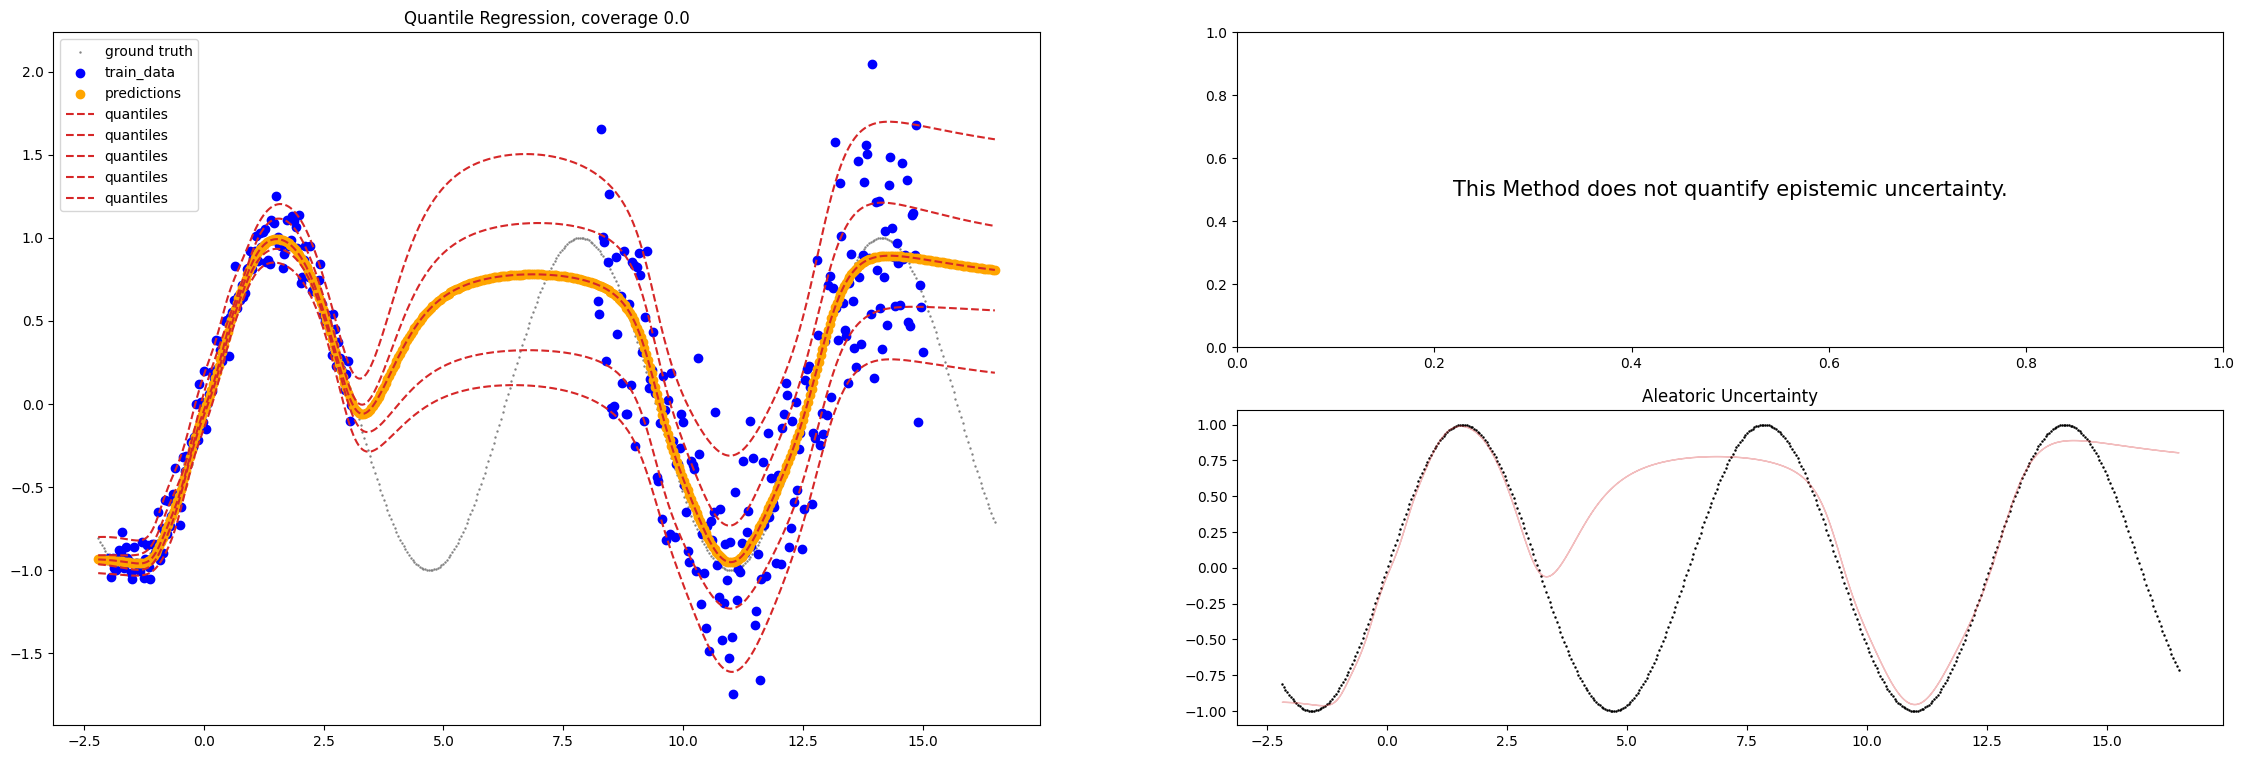

<Figure size 2800x900 with 0 Axes>

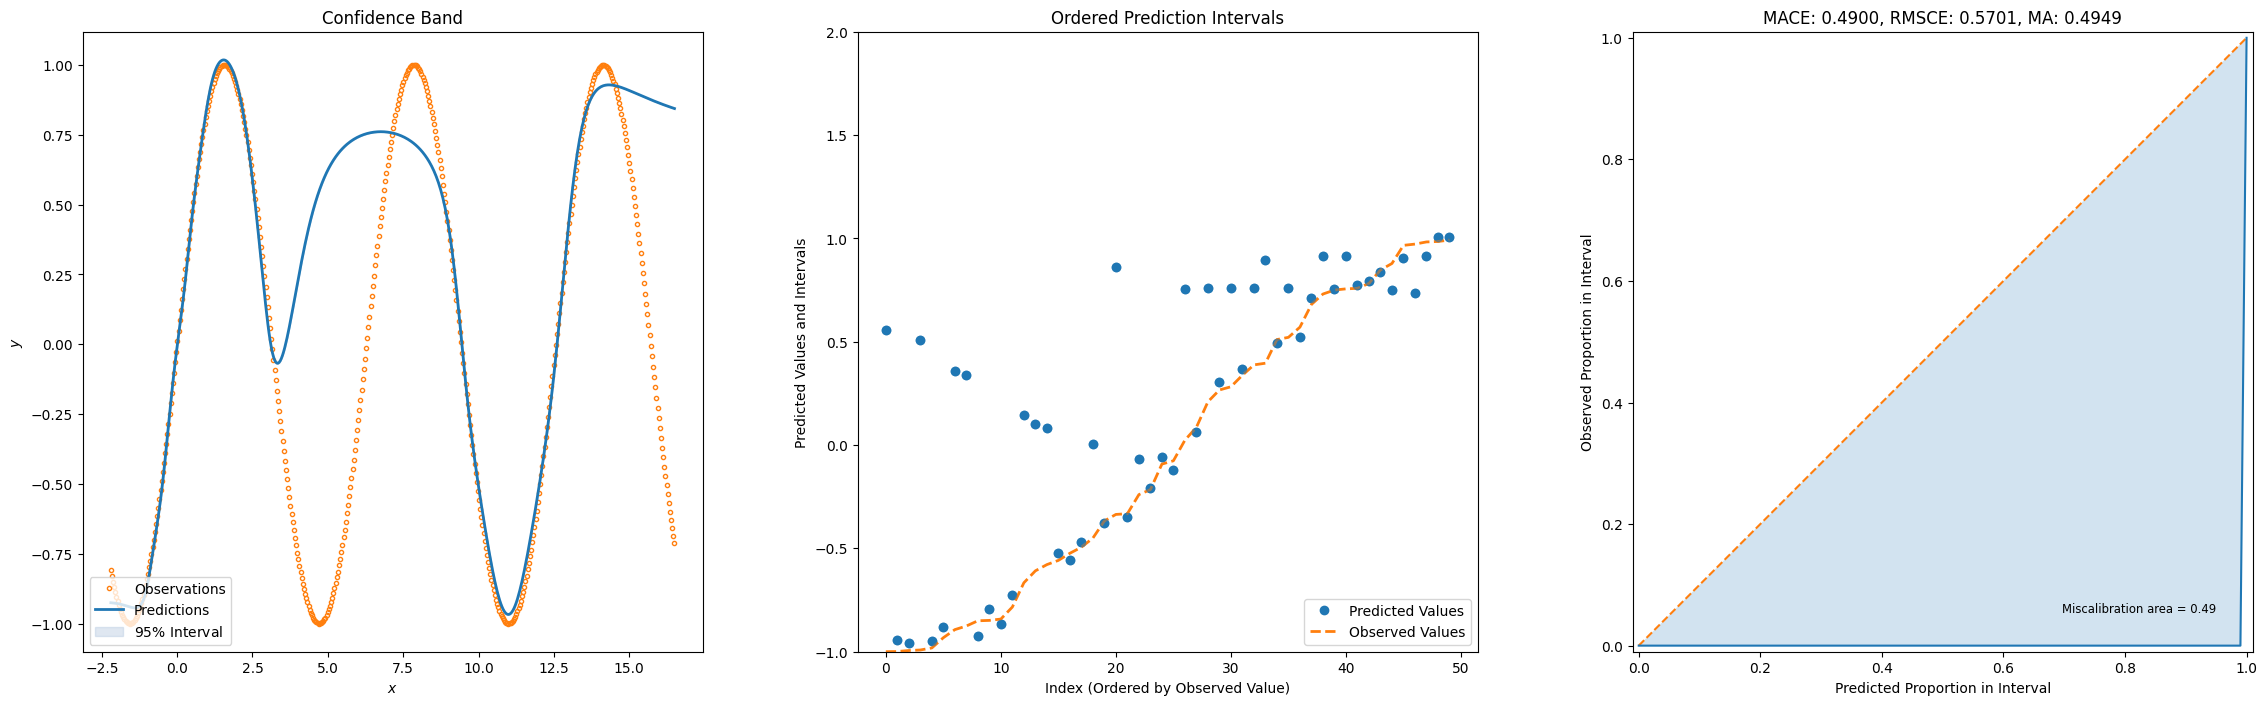

In [13]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    quantile_median,
    pred_quantiles=quantile_preds,
    aleatoric=q_model_std,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(
    q_model_mean, q_model_std, y_test_cpu.squeeze(), X_test_cpu.squeeze()
)

## Conformal Prediction

In [17]:
def conformalized_scores(
    cal_preds: np.ndarray, cal_labels: np.ndarray, test_preds: np.ndarray, quantiles
) -> np.ndarray:
    """Implements conformalized Quantile Regression

    Args:
      calib_preds: calibration set predictions
      calib_labels: calibration set targets
      test_preds: test set predictions that will be conformalized predictions
      quantiles: quantiles

    Returns:
      conformalized prediction sets (adjusted quantile bands)
    """
    cal_labels = cal_labels.squeeze()
    alpha = 1 - max(quantiles)  # 1-alpha is the desired coverage
    n = cal_labels.shape[0]
    cal_upper = cal_preds[:, -1]
    cal_lower = cal_preds[:, 0]

    # Get scores. cal_upper.shape[0] == cal_lower.shape[0] == n
    cal_scores = np.maximum(cal_labels - cal_upper, cal_lower - cal_labels)

    # Get the score quantile
    qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, method="linear")

    # Deploy (output=lower and upper adjusted quantiles)
    conformal_prediction_sets = np.stack(
        [cal_lower - qhat, test_preds[:, quantiles.index(0.5)], cal_upper + qhat],
        axis=1,
    )
    return conformal_prediction_sets

## conformalized Prediction with Quantile Regression

In [18]:
quantile_cp_sets = conformalized_scores(
    quantile_preds, y_test_cpu, quantile_preds, quantiles
)

cp_qr_model_mean, cp_qr_model_std = compute_sample_mean_std_from_quantile(
    quantile_cp_sets, quantiles
)

results_dict["cp"] = {"mean": cp_qr_model_mean, "std": cp_qr_model_std}

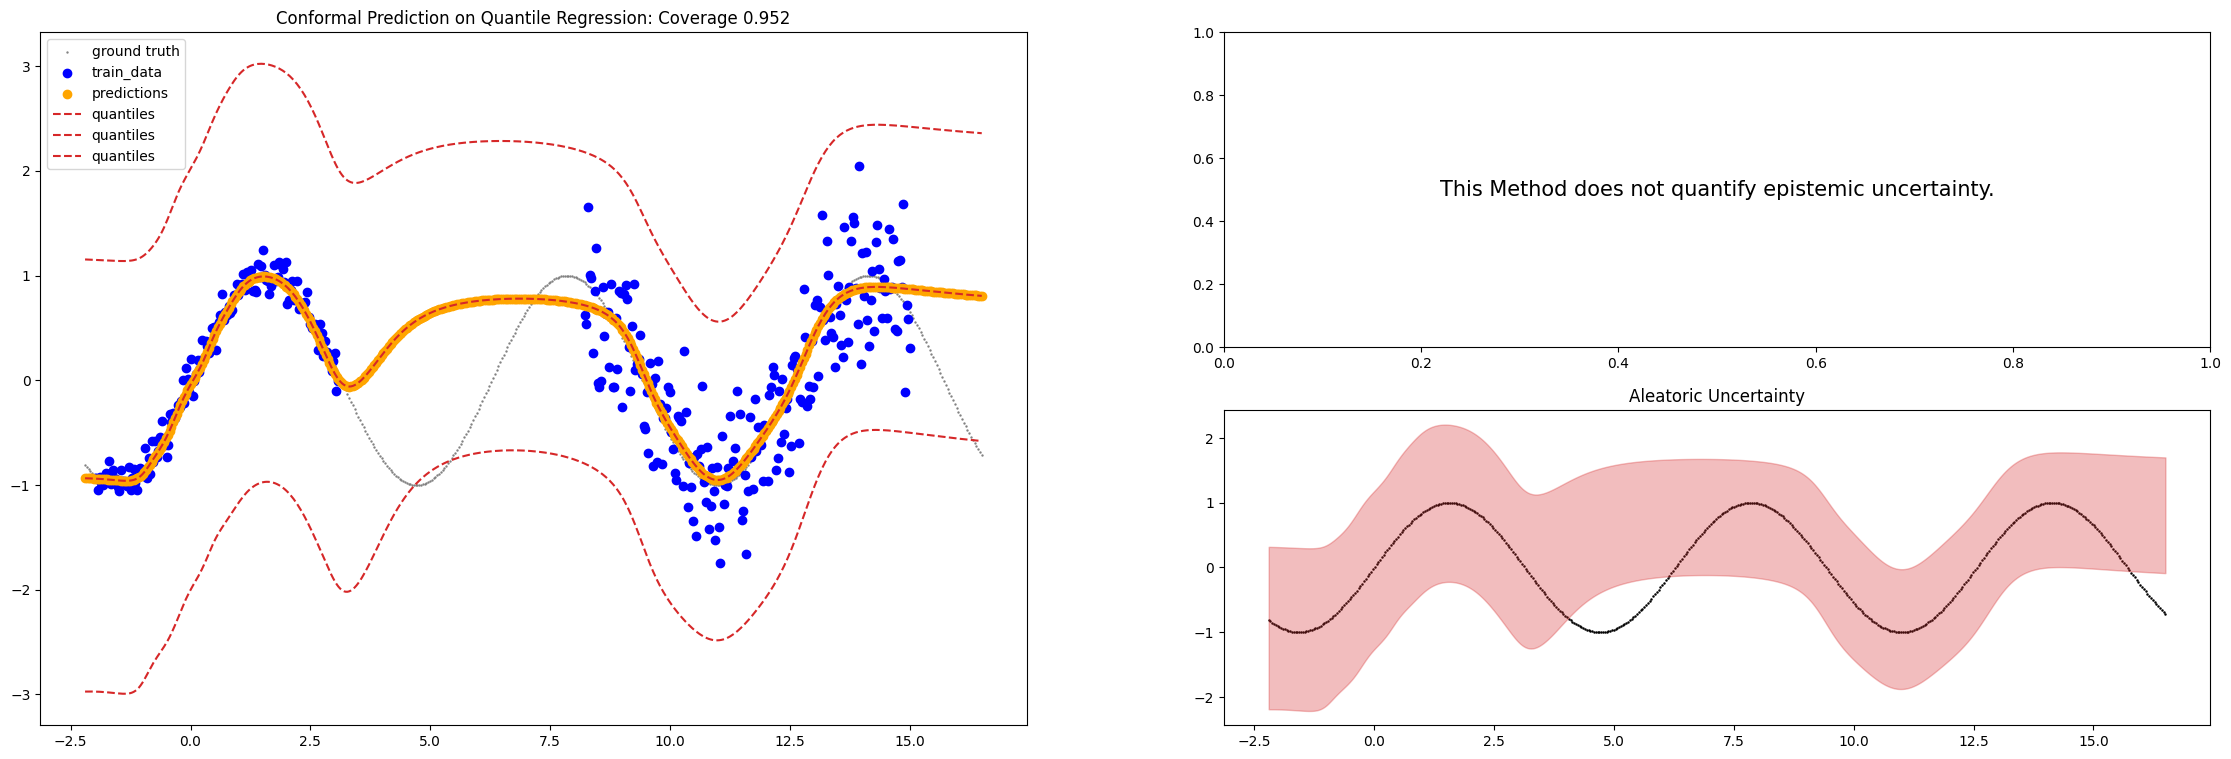

<Figure size 2800x900 with 0 Axes>

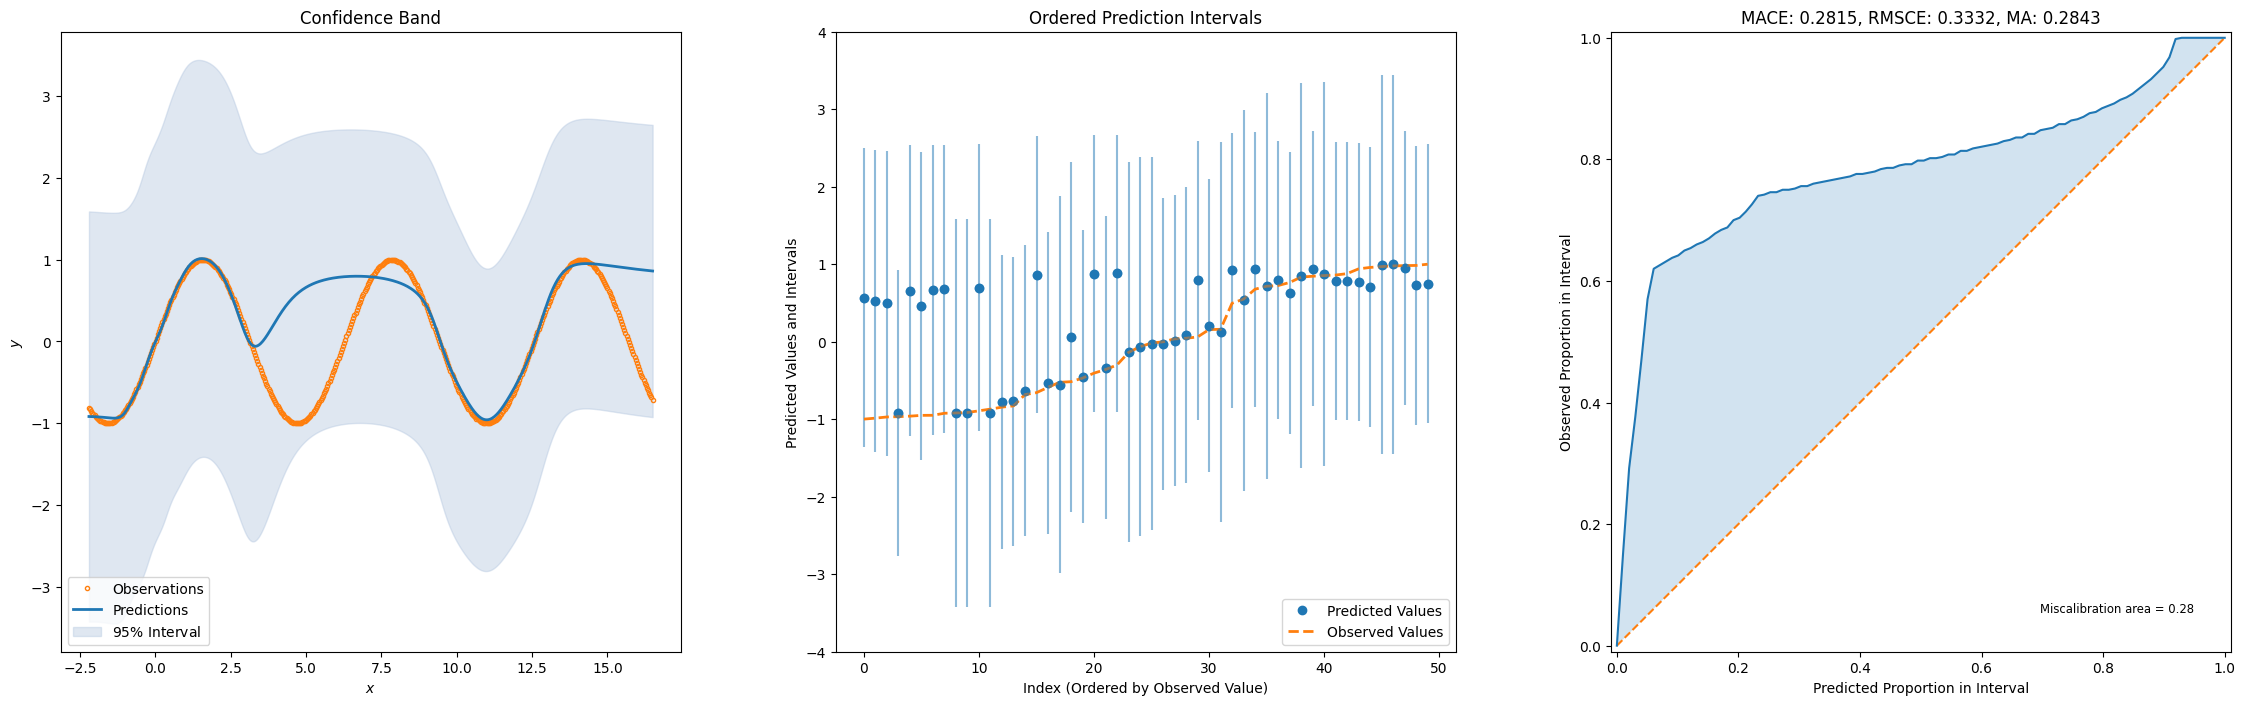

In [19]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    quantile_median,
    pred_quantiles=quantile_cp_sets,
    aleatoric=cp_qr_model_std,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(quantile_cp_sets, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cp_qr_model_mean, cp_qr_model_std, y_test_cpu, X_test_cpu)